In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import io
import numpy as np
import pandas as pd
import datetime as dt

pd.options.display.max_columns = 200

# https://github.com/facebook/prophet/issues/999
pd.plotting.register_matplotlib_converters()
from fbprophet import Prophet

import statsmodels.formula.api as smf
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using Births dataset:

Will we be able to locate the Baby Boom in the United States using this data? If so, what other interesting trends can we see playing out in the United States over the next several years? 

To start, let's load our dataset and check the head.

In [ ]:
birth_df = pd.read_csv("https://raw.githubusercontent.com/kjhealy/us_births/master/data/usa_birth_1933-2015.csv")

In [ ]:
birth_df.head()

,PopName,Area,Year,YearReg,Month,Vital,RefCode,Access,Births,Note1,Note2,Note3,LDB
0,USA,2,1933,1933,1,1,17,O,180545,.,.,.,1
1,USA,2,1933,1933,2,1,17,O,165986,.,.,.,1
2,USA,2,1933,1933,3,1,17,O,183762,.,.,.,1
3,USA,2,1933,1933,4,1,17,O,171354,.,.,.,1
4,USA,2,1933,1933,5,1,17,O,174811,.,.,.,1


Currently, there is no date column that includes monthly data. Let's add one so we can better visualize our data using y/m/d.

In [ ]:
birth_df.insert(loc = 1, column = 'Day', value = 1)

We'll also drop yearly total of births by getting rid of the TOT month, which represents the total for the year.

In [ ]:
#Drop TOT value for each year
totless_birth_df = (birth_df.loc[(birth_df["Month"] != "TOT")])

In [ ]:
totless_birth_df["Date"] = pd.Series(pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(totless_birth_df.Year, totless_birth_df.Month, totless_birth_df.Day)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Now, let's take a look out our data trends and see if we can find anything interesting. 

There's our baby boom! We can clearly see the post-war upswing, marked by the dotted red line. It also looks like there was a bit of normalization in the 60s and 70s after the boom before picking up again in the 80s. 

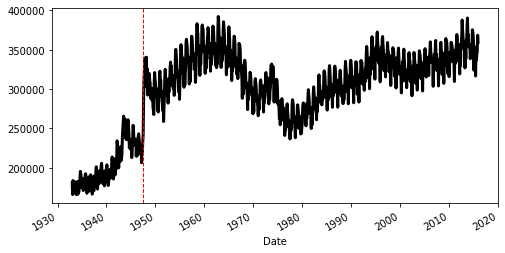

In [ ]:
# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(8,4))

# Put the "date" column as an index, access the remaining "passengers" column, and plot on the ax defined above
totless_birth_df.set_index('Date')['Births'].plot(c='k',lw=3,ax=ax)

# Make a vertical red line on WW2 end
ax.axvline(pd.Timestamp('1947-06-01'),color='r',ls='--',lw=1)

Find the rolling mean in the data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


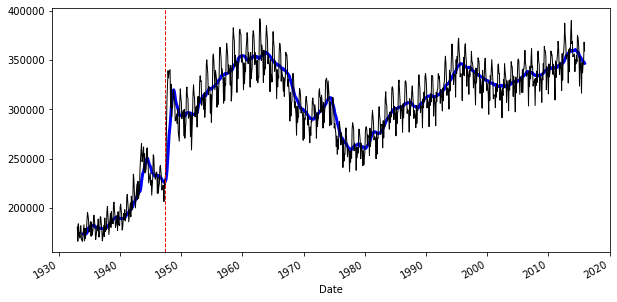

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,5))
totless_birth_df['rolling_mean_Births'] = totless_birth_df['Births'].rolling(window = 12).mean()

totless_birth_df.set_index('Date')['rolling_mean_Births'].plot(c='b',lw=3,ax=ax)
totless_birth_df.set_index('Date')['Births'].plot(c='k',lw=1,ax=ax)
ax.axvline(pd.Timestamp('1947-06-01'),color='r',ls='--',lw=1)

Check the average distribution of births in each month of the year.

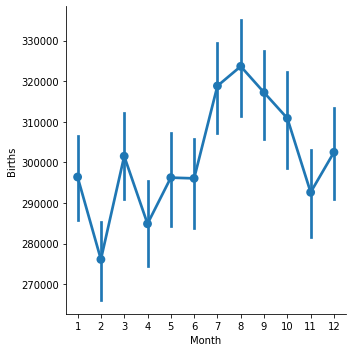

In [ ]:
sb.catplot(x='Month',y='Births', data=totless_birth_df, freq = "none", kind='point')

Taking a look at our decomposed time-series into its seasonal, trend, and residual components. 

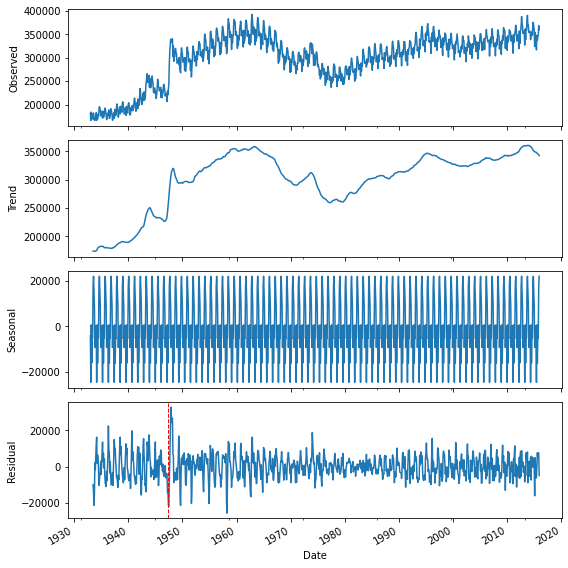

In [ ]:
decomposition = sm.tsa.seasonal_decompose(totless_birth_df.set_index('Date')['Births'], freq = 12, model='additive')

plt.rcParams["figure.figsize"] = (8,8)
f = decomposition.plot()

f.axes[-1].axvline(pd.Timestamp('1947-06-01'),color='r',ls='--',lw=1)

Now we'll try to fit a simple pairwise linear model. We'll need to calculate our births from the beginning of our dataset to now using the "births_since33" variable because the Timestamp objects are not the simple integers or floats that seaborn's lmplot or statsmodel's ols expects.

In [ ]:
totless_birth_df['births_since33'] = (totless_birth_df['Date'] - pd.Timestamp('1933-01-01'))/pd.Timedelta(30.33,'Days')
totless_birth_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PopName,Day,Area,Year,YearReg,Month,Vital,RefCode,Access,Births,Note1,Note2,Note3,LDB,Date,rolling_mean_Births,births_since33
0,USA,1,2,1933,1933,1,1,17,O,180545,.,.,.,1,1933-01-01,NaN,0.000000
1,USA,1,2,1933,1933,2,1,17,O,165986,.,.,.,1,1933-02-01,NaN,1.022090
2,USA,1,2,1933,1933,3,1,17,O,183762,.,.,.,1,1933-03-01,NaN,1.945269
3,USA,1,2,1933,1933,4,1,17,O,171354,.,.,.,1,1933-04-01,NaN,2.967359
4,USA,1,2,1933,1933,5,1,17,O,174811,.,.,.,1,1933-05-01,NaN,3.956479


Well the trend is roughly linear, but the baby boom definitely stresses this assumption.

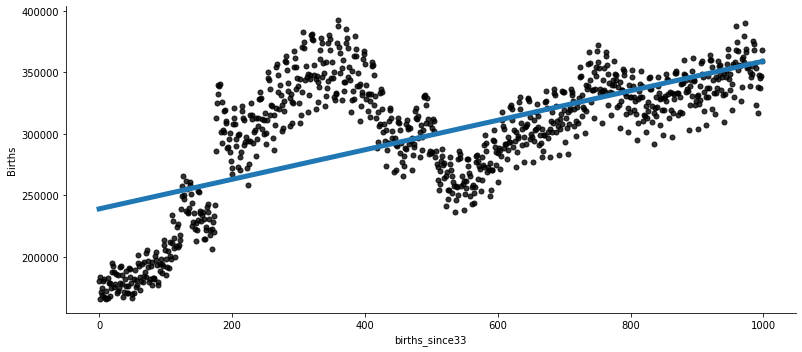

In [ ]:
# Make the lmplot using seaborn
g = sb.lmplot(x='births_since33',y='Births',data=totless_birth_df,aspect=2.25,ci=0,
              scatter_kws={'color':'k','s':25},line_kws={'lw':5})

# Access the underlying ax object
ax = g.axes[0,0]

Using the dependend variable of Births, we have a somewhat poor model with an R^2 of 41.6%. 

In [ ]:
m0 = smf.ols('Births ~ births_since33',data= totless_birth_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Births   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     653.3
Date:                Tue, 19 Apr 2022   Prob (F-statistic):          2.96e-109
Time:                        14:29:57   Log-Likelihood:                -11078.
No. Observations:                 920   AIC:                         2.216e+04
Df Residuals:                     918   BIC:                         2.217e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.391e+05   2705.854     88.362      0.000    2.34e+05    2.44e+05
births_since33   119.9541      4.693     25.560      0.000     110.744     129.164
==============================================================================
Omnibus:                       33.230   Durbin-Watson:                   0.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.059
Skew:                           0.428   Prob(JB):                     6.63e-08
Kurtosis:                       2.640   Cond. No.                     1.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using the rolling mean gives us a very slightly better R^2 of 44.1%, but still not a great model. 

In [ ]:
m1 = smf.ols('rolling_mean_Births ~ births_since33',data= totless_birth_df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rolling_mean_Births   R-squared:                       0.441
Model:                             OLS   Adj. R-squared:                  0.440
Method:                  Least Squares   F-statistic:                     714.1
Date:                 Tue, 19 Apr 2022   Prob (F-statistic):          1.67e-116
Time:                         14:29:59   Log-Likelihood:                -10874.
No. Observations:                  909   AIC:                         2.175e+04
Df Residuals:                      907   BIC:                         2.176e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.398e+05   2560.552     93.665      0.000    2.35e+05    2.45e+05
births_since33   117.9668      4.414     26.723      0.000     109.303     126.630
==============================================================================
Omnibus:                       36.193   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.834
Skew:                           0.336   Prob(JB):                     9.04e-07
Kurtosis:                       2.468   Cond. No.                     1.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Auto-correlation

Here we will reshape our temporal data to remove cycles. This will help us try to gain some sort of independence of observations. 

We will use shift to create new columns that are shifted by a single or multiple rows so we can correlate births in one month with birth values in adjacent months.

In [ ]:
totless_birth_df['births_shift_1'] = totless_birth_df['Births'].shift(1)
totless_birth_df['births_shift_2'] = totless_birth_df['Births'].shift(2)
totless_birth_df['births_shift_3'] = totless_birth_df['Births'].shift(3)
totless_birth_df['births_shift_4'] = totless_birth_df['Births'].shift(4)
totless_birth_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,PopName,Day,Area,Year,YearReg,Month,Vital,RefCode,Access,Births,Note1,Note2,Note3,LDB,Date,rolling_mean_Births,births_since33,births_shift_1,births_shift_2,births_shift_3,births_shift_4
0,USA,1,2,1933,1933,1,1,17,O,180545,.,.,.,1,1933-01-01,NaN,0.000000,NaN,NaN,NaN,NaN
1,USA,1,2,1933,1933,2,1,17,O,165986,.,.,.,1,1933-02-01,NaN,1.022090,180545.0,NaN,NaN,NaN
2,USA,1,2,1933,1933,3,1,17,O,183762,.,.,.,1,1933-03-01,NaN,1.945269,165986.0,180545.0,NaN,NaN
3,USA,1,2,1933,1933,4,1,17,O,171354,.,.,.,1,1933-04-01,NaN,2.967359,183762.0,165986.0,180545.0,NaN
4,USA,1,2,1933,1933,5,1,17,O,174811,.,.,.,1,1933-05-01,NaN,3.956479,171354.0,183762.0,165986.0,180545.0


Now correlate "Births", "births_shift_1", "births_shift_2", etc. The correlations for "Births" (first columns) at adjacent points in time is extremely strong: this is clearly a violation of the independence assumption because the values at different points in time are not independent but strongly correlated with the preceding and succeeding values.

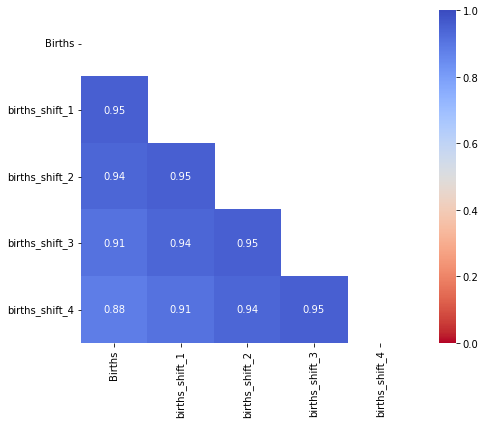

In [ ]:
births_corr = totless_birth_df[['Births','births_shift_1','births_shift_2','births_shift_3','births_shift_4']].corr()

# Using masking code from: https://seaborn.pydata.org/generated/seaborn.heatmap.html
births_mask = np.zeros_like(births_corr)
births_mask[np.triu_indices_from(births_mask)] = True

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(8,6))

# Make a heatmap
sb.heatmap(births_corr,vmin=0,vmax=1,mask=births_mask,annot=True,square=True,ax=ax,cmap='coolwarm_r')

f.tight_layout()

Autocorrelation can be seen in the adjacent time points' values. Even the shifted variables are also correlated with each other, we need to control for the correlations in these other shifts/lags to recover the "true" correlation in the adjacent time series. 

Partial autocorrelation does exactly this.

The partial autocorrelations still show strong signals at 12 months, 24 months, etc. This captures the fact that birth activity in one month one year is similar to the month in the next year.

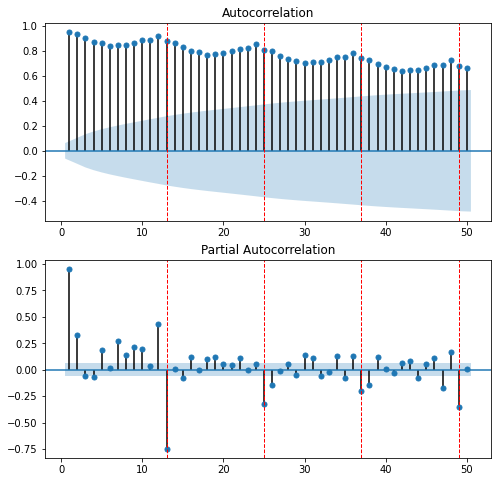

In [ ]:
f,axs = plt.subplots(2,1,figsize=(8,8))

fig1 = sm.graphics.tsa.plot_acf(totless_birth_df['Births'],zero=False,lags=50,ax=axs[0],alpha=.05)
fig2 = sm.graphics.tsa.plot_pacf(totless_birth_df['Births'],zero=False,lags=50,ax=axs[1],alpha=.05)

for ax in axs:
    ax.axvline(13,c='r',ls='--',lw=1)
    ax.axvline(25,c='r',ls='--',lw=1)
    ax.axvline(37,c='r',ls='--',lw=1)
    ax.axvline(49,c='r',ls='--',lw=1)

Pandas can also make an autocorrelation correlograms with .plotting.autocorrelation_plot. The dashed lines are the confidence interval where values above this are statistically significant correlation and unlikely to be noise (as above).

(1.0, 50.0)

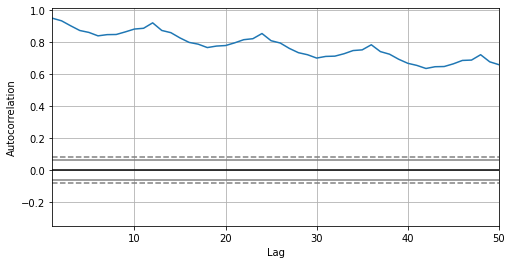

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,4))

ax = pd.plotting.autocorrelation_plot(totless_birth_df['Births'],ax=ax)
ax.set_xlim((1,50))

Now we will attempt to forecast temporal data using Prophet.

In [ ]:
# Copy the relevant columns to a new DataFrame
prophet_births = totless_birth_df[['Date','Births']].copy()

# Rename the columns how Prophet wants
prophet_births.rename(columns={'Date':'ds','Births':'y'},inplace=True)

# Inspect
prophet_births = prophet_births.dropna()
prophet_births

,ds,y
0,1933-01-01,180545
1,1933-02-01,165986
2,1933-03-01,183762
3,1933-04-01,171354
4,1933-05-01,174811
...,...,...
991,2015-08-01,337272
992,2015-09-01,345257
993,2015-10-01,346971
994,2015-11-01,368450


Fit the model with this data at the monthly level.

In [ ]:
m2 = Prophet(weekly_seasonality=False,daily_seasonality=False).fit(prophet_births)

We can use the make_future_dataframe method attached to the m2 model we just estimated to make predictions into the future.

In [ ]:
m2_future = m2.make_future_dataframe(periods=120,freq='M')

# Inspect the tail to make sure it's monthly
m2_future.tail()

,ds
1035,2025-07-31
1036,2025-08-31
1037,2025-09-30
1038,2025-10-31
1039,2025-11-30


In [ ]:
m2_forecast = m2.predict(m2_future)

# Lots of columns returned, just look at the choice ones
m2_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1035,2025-07-31,363741.947004,331453.084053,392662.387121
1036,2025-08-31,362718.565282,331243.761738,390678.499099
1037,2025-09-30,357211.611863,327153.440410,386862.665404
1038,2025-10-31,362331.797341,332541.047875,388358.710060
1039,2025-11-30,363236.784832,332416.751996,393148.649974


Looking at the historical data (black points), the line connecting these points, and the forecast into the future with errors -- at appears as though the United States is on track for some relatively steady-small growth over the next few years.

Text(0.5, 1.0, 'Observation and Forecast of United States Births')

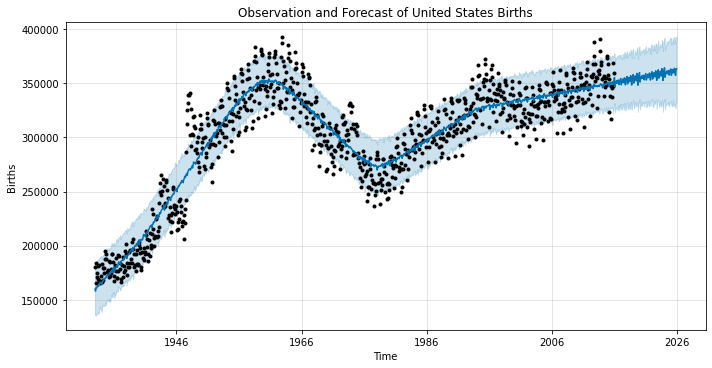

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,5))
_ = m2.plot(m2_forecast,ax=ax)

# Always label your axes
ax.set_xlabel('Time')
ax.set_ylabel('Births')
ax.set_title('Observation and Forecast of United States Births')

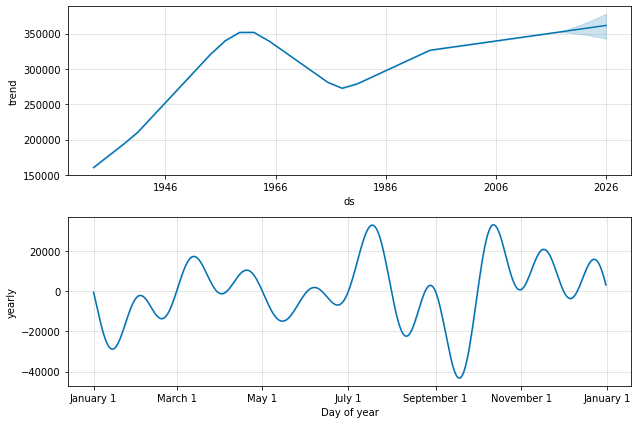

In [ ]:
# Estimate trend and annually cyclical pattern
f = m2.plot_components(m2_forecast)

This annual cyclical variation should look similar to the pointplot we made above for exploring the month-to-month differences that motivated our fixed effects model, however the September dip doesn't seem to be following that trend. 

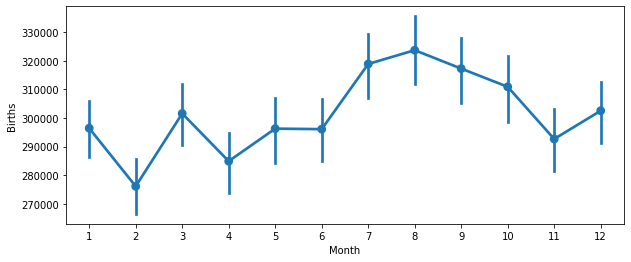

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,4))
sb.pointplot(x='Month',y='Births',data=totless_birth_df,ax=ax)

##Write Up

Using the births dataset, we want to get a better picture of what trends might be in the United States for the coming years. Checking the data set, we are given the year of births, the month of births, but no date of births. Part of this cleanup revolves around establishing a fixed date column. We did this by adding a days column and setting each day of birth to one. Now having a year, month, and day column, we were able to create it an actual date column in the format that can be better read as an index. When checking the initial plot from 1933 to present, we can see a massive spike during the baby boom in 1947. This spike lasted through the mid 60s which is when births slowed down from about 1965 to 1985. These numbers were on a yearly scale, but we can also see trends monthly with the biggest spikes happening in July, August, and September. Looking at correlation numbers, we can see that everything birth wise is very correlated. Shifting up to four, we can see correlation around 90% in each case. In our partial autocorrelation trends, we can see that in February we are consistently getting a lot less births overtime. This follows the trend we were seeing on the monthly pattern. We can also see the dramatic spike for the baby boom. Projecting this data out using Prophet, it is clear a slight upward trend can be considered from now through about 2026 given historical data. My annual cyclical variation within profit should look similar to the point plot, however for some reason the fall months aren’t playing nice. Don’t know why that is.